<a href="https://colab.research.google.com/github/avirooppal/Differential-Privacy-in-Federated-Learning/blob/main/Federated_Learning_with_Differential_Privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install numpy matplotlib

Scenario-
Two IoT devices (e.g., GPS trackers) collect 2D location data (latitude, longitude). They want to collaboratively build a global model (e.g., average location), without exposing their private data.

How It Works-
Data Simulation: Each device generates 100 samples of 2D location data.
Local Training: Devices compute the mean of their local data.
Differential Privacy: Laplace noise is added to each local update.
Global Aggregation: The server averages the noisy updates to produce a global model.

Key Points-
Protects privacy using the Laplace Mechanism.
Enables decentralized collaboration without sharing raw data.


Devices: 2
True Global Mean: [0.49562385 0.49415505]
DP Global Mean  : [0.66798576 0.13218452]
Error (L2 norm) : 0.4009130738007136

Devices: 5
True Global Mean: [0.48130526 0.51663662]
DP Global Mean  : [0.30877828 0.42250559]
Error (L2 norm) : 0.19653552257010717

Devices: 10
True Global Mean: [0.50027397 0.49768103]
DP Global Mean  : [0.36901432 0.79632105]
Error (L2 norm) : 0.32621306129493655

Devices: 20
True Global Mean: [0.49528607 0.4917847 ]
DP Global Mean  : [0.59924901 0.3824297 ]
Error (L2 norm) : 0.15088674051236656

Devices: 50
True Global Mean: [0.5019951  0.49783039]
DP Global Mean  : [0.4620374  0.56900904]
Error (L2 norm) : 0.08162731149816871

Devices: 100
True Global Mean: [0.50013106 0.50187032]
DP Global Mean  : [0.48696966 0.32696567]
Error (L2 norm) : 0.17539914618098787


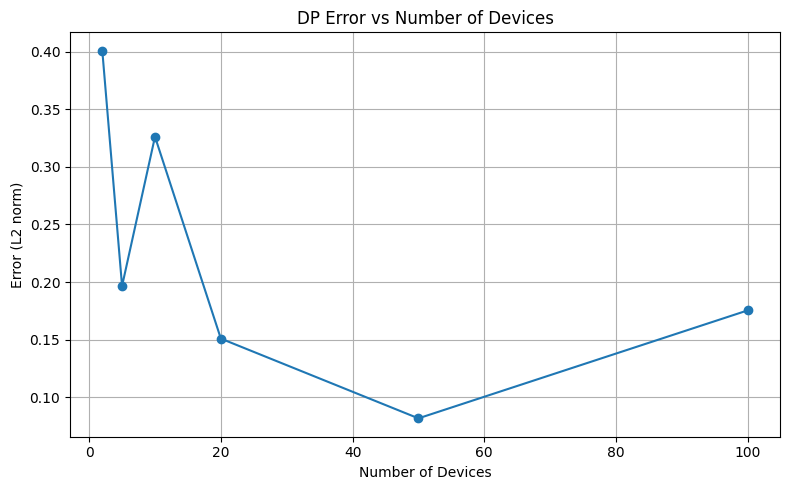

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def generate_device_data(n_samples=100):
    return np.random.rand(n_samples, 2)

def local_train(data):
    return np.mean(data, axis=0)

def add_dp_noise(update, epsilon=1.0, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, size=update.shape)
    return update + noise

device_counts = [2, 5, 10, 20, 50, 100]
errors = []

for num_devices in device_counts:
    updates = []
    dp_updates = []

    for _ in range(num_devices):
        data = generate_device_data()
        local_update = local_train(data)
        dp_update = add_dp_noise(local_update, epsilon=1.0)
        updates.append(local_update)
        dp_updates.append(dp_update)

    true_global = np.mean(updates, axis=0)
    dp_global = np.mean(dp_updates, axis=0)

    error = np.linalg.norm(dp_global - true_global)
    errors.append(error)

    print(f"\nDevices: {num_devices}")
    print("True Global Mean:", true_global)
    print("DP Global Mean  :", dp_global)
    print("Error (L2 norm) :", error)


plt.figure(figsize=(8, 5))
plt.plot(device_counts, errors, marker='o')
plt.title("DP Error vs Number of Devices")
plt.xlabel("Number of Devices")
plt.ylabel("Error (L2 norm)")
plt.grid(True)
plt.tight_layout()
plt.show()

Federated Learning with DP for N Users —
This uses:

MNIST

Simulated FL with any number of clients

Manual DP (gradient clipping + Gaussian noise)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
NUM_USERS = 10
BATCH_SIZE = 32
ROUNDS = 10
EPOCHS_PER_CLIENT = 1
CLIP_NORM = 1.0
NOISE_MULTIPLIER = 1.0
LEARNING_RATE = 0.1

In [ ]:
# Load MNIST dataset
transform = transforms.ToTensor()
full_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128)

In [ ]:
data_per_user = len(full_dataset) // NUM_USERS
user_datasets = [Subset(full_dataset, list(range(i * data_per_user, (i + 1) * data_per_user))) for i in range(NUM_USERS)]

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

In [ ]:
def train_local_dp(model, dataset, lr=0.1, epochs=1, clip=1.0, noise=1.0):
    model = copy.deepcopy(model)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for _ in range(epochs):
        for x, y in loader:
            optimizer.zero_grad()
            output = model(x)
            loss = F.cross_entropy(output, y)
            loss.backward()

            # Gradient clipping
            total_norm = torch.sqrt(sum(p.grad.data.norm(2)**2 for p in model.parameters()))
            clip_coef = clip / (total_norm + 1e-6)
            if clip_coef < 1.0:
                for p in model.parameters():
                    p.grad.data.mul_(clip_coef)

            # Add Gaussian noise
            for p in model.parameters():
                noise_tensor = torch.normal(0, noise * clip, size=p.grad.shape)
                p.grad.data.add_(noise_tensor)

            optimizer.step()

    return model.state_dict()

In [ ]:
def average_models(models):
    avg = copy.deepcopy(models[0])
    for key in avg:
        for i in range(1, len(models)):
            avg[key] += models[i][key]
        avg[key] /= len(models)
    return avg

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
global_model = Net()
accuracy_history = []

for rnd in range(ROUNDS):
    user_models = []
    for user_data in user_datasets:
        local_state = train_local_dp(
            global_model,
            user_data,
            lr=LEARNING_RATE,
            epochs=EPOCHS_PER_CLIENT,
            clip=CLIP_NORM,
            noise=NOISE_MULTIPLIER
        )
        user_models.append(local_state)

    global_state = average_models(user_models)
    global_model.load_state_dict(global_state)

    acc = evaluate(global_model, test_loader)
    accuracy_history.append(acc)
    print(f"Round {rnd+1} - Global Accuracy: {acc:.4f}")

Round 1 - Global Accuracy: 0.6146
Round 2 - Global Accuracy: 0.6857
Round 3 - Global Accuracy: 0.7250
Round 4 - Global Accuracy: 0.7488
Round 5 - Global Accuracy: 0.7531
Round 6 - Global Accuracy: 0.7601
Round 7 - Global Accuracy: 0.7763
Round 8 - Global Accuracy: 0.7778
Round 9 - Global Accuracy: 0.7808
Round 10 - Global Accuracy: 0.7836


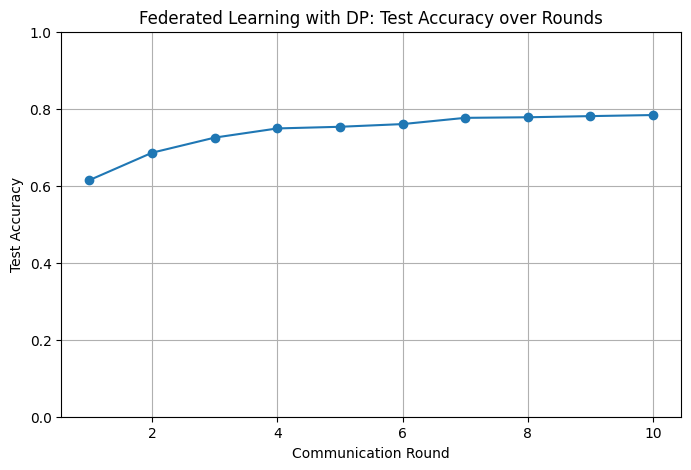

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, ROUNDS + 1), accuracy_history, marker='o')
plt.title("Federated Learning with DP: Test Accuracy over Rounds")
plt.xlabel("Communication Round")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()